In [1]:
# aim of this notebook: get MLE working on some sort of exponential * sine combination. (no PSD just yet)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
%matplotlib inline

def log_likelihood(func, fit_to):
    def get_ll(pars):
        pars_model, sd = pars[:len(pars)-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(norm.logpdf(fit_to, loc=data_predicted, scale=sd))
        return LL
    return get_ll

def get_pars_mle(func, data_actual, pars_init):
    ll = log_likelihood(func, data_actual)
    results = minimize(ll, pars_init, method='Nelder-Mead')
    return results.x

def get_data_model(func, pars_mle):
    return func(pars_mle[:-1])

In [25]:
f_sampling = 1000
times = np.arange(0, 1, 1/f_sampling)
A = np.random.uniform(low=0.1, high=1) #mas
f = np.random.uniform(low=f_sampling/60, high=f_sampling/3) #Hz
k = np.random.uniform(low=1e-5, high=1e-4) # unitless
p = np.random.uniform(low=0, high=2*np.pi) # rad
bounds = [(0.1, 1), (f_sampling/60, f_sampling/3), (1e-5, 1e-4), (0, 2*np.pi), (0, None)]
pars_actual = [A, f, k, p]
pars_actual = [0.8, 21, 8e-5, 6]
pars_guess = [0.8, 0.175*f_sampling, 1e-5, np.pi, 1000]

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

Actual parameters: [0.8, 21, 8e-05, 6]
Maximum-likelihood estimated parameters: [5.98955000e-04 2.02421918e+02 1.99830516e-05 5.54201334e+00]
SD of fit: 0.5627252405256202


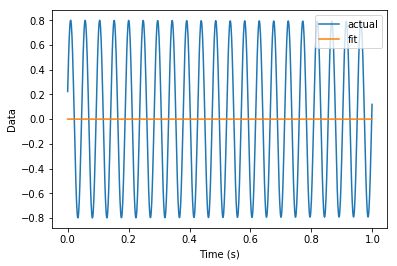

In [26]:
data_dh = damped_harmonic(pars_actual)
pars_mle = get_pars_mle(damped_harmonic, data_dh, pars_guess)
data_model = get_data_model(damped_harmonic, pars_mle)

print("Actual parameters: " + str(pars_actual))
print("Maximum-likelihood estimated parameters: " + str(pars_mle[:-1]))
print("SD of fit: " + str(pars_mle[-1]))
plt.plot(times, data_dh, label='actual')
plt.plot(times, data_model, label='fit')
plt.xlabel("Time (s)")
plt.ylabel("Data")
plt.legend()

Text(0,0.5,'Data residual')

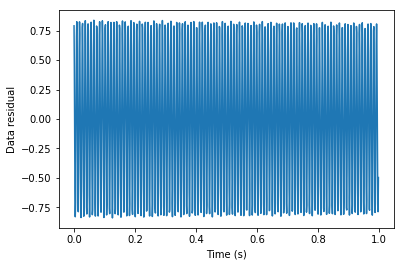

In [16]:
plt.plot(times, data_model-data_dh, label='residual')
plt.xlabel("Time (s)")
plt.ylabel("Data residual")

In [ ]:
# okay...now for the same thing but with PSD fitting

from scipy.signal import periodogram

def psd(pars_model):
    return periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

freqs = periodogram(damped_harmonic(pars_guess[:-1]), fs=f_sampling)[0]
data_psd = psd(pars_actual)
pars_mle_psd = get_pars_mle(psd, data_psd, pars_guess)
data_model_psd = get_data_model(psd, pars_mle_psd)

print("Actual parameters: " + str(pars_actual))
print("Maximum-likelihood estimated parameters: " + str(pars_mle_psd[:-1]))
print("SD of fit: " + str(pars_mle_psd[-1]))
plt.semilogy(freqs, data_model_psd, label='fit')
plt.semilogy(freqs, data_psd, label='actual')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Data")
plt.legend()

In [ ]:
residual = np.abs(data_model - data_psd)